# Libraries

In [1]:
# Standards
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Boosted Decision Tree (BDT)
import lightgbm as lgb

# Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay

In [3]:
#Simple timer for LGBM

import time
class Timer:
    def __init__(self,every=100):
        self.start = time.time()
        self.every = every
        
    def __call__(self,CallbackEnv):
        i = CallbackEnv.iteration
        if i%self.every == 0:
            print(f"Iteration: {i}")
            self.print_time()
            
    def print_time(self):
        print(f"Total time elapsed: {time.time()-self.start:.2f}s")

# Prework

## Loading data

In [4]:
data_all = pd.read_hdf("ATLAS_electrons.h5").sample(5_000)
display(data_all)

,averageInteractionsPerCrossing,p_Rhad1,p_Rhad,p_f3,p_weta2,p_Rphi,p_Reta,p_Eratio,p_f1,p_TRTPID,...,pX_E7x11_Lr2,pX_E7x11_Lr3,pX_E7x7_Lr0,pX_E7x7_Lr1,p_pt_track,p_eta,p_phi,p_charge,p_Truth_isElectron,p_Truth_Energy
93998,30.500000,0.085388,0.087791,0.015951,0.013018,0.839868,0.714918,0.380597,0.282869,-0.070225,...,27768.367188,803.530334,2394.165771,9545.546875,1448.026978,-0.736815,0.366214,1.0,0,1839.995239
166027,53.500000,0.239282,0.351181,0.006370,0.008442,0.636033,0.654684,0.945898,0.329543,-0.090363,...,18821.023438,473.141815,1533.816162,7228.976562,15795.710938,0.286532,2.048098,-1.0,0,16233.575195
166242,55.500000,0.163077,0.204924,0.059892,0.010332,0.920954,0.857216,0.131885,0.052466,0.055265,...,37704.261719,3247.019531,2604.589600,3956.754150,25733.765625,0.761030,-1.012964,1.0,0,32907.390625
71429,35.500000,0.139792,0.191488,0.016573,0.016812,0.791114,0.898838,0.150267,0.357764,-0.183204,...,23954.070312,547.187256,6226.722168,14798.191406,6957.807617,1.537913,1.656750,1.0,0,-999.000000
146402,45.490002,0.288950,0.360354,0.010085,0.011467,0.853605,0.887272,0.235081,0.260369,-0.213215,...,22710.228516,622.884949,1071.814331,7777.029297,18465.347656,0.118139,2.631097,1.0,0,18579.150391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2744,40.490002,0.113183,0.138959,0.111855,0.011851,0.811018,0.664705,0.385404,0.177935,0.221141,...,32378.396484,4681.324707,5952.352539,7617.140625,14088.363281,1.045925,0.758575,-1.0,1,5675.977051
105615,45.490002,0.371052,0.382341,0.052728,0.014612,0.858824,0.588540,0.904020,0.358981,0.125186,...,33961.625000,3594.864258,3899.150391,20560.191406,10088.449219,-0.742003,0.546539,1.0,0,12919.901367
79555,42.490002,0.578622,0.866751,0.012517,0.013350,0.672962,0.671186,0.868304,0.269112,-0.102852,...,38148.652344,5478.605469,8799.012695,16627.193359,15721.929688,1.240982,0.082573,1.0,0,28650.949219
137072,45.490002,0.329115,0.610103,0.066545,0.013226,0.586418,0.802111,0.133799,0.423870,0.303481,...,47587.304688,5492.662598,5586.212891,21281.175781,2040.275391,-1.746377,-3.136106,-1.0,0,5503.655762


## Split data into labels and features

In [5]:
best_features = ['p_Rhad','p_sigmad0','p_TRTPID','p_deltaEta1','p_etcone20','p_numberOfInnermostPixelHits',
                 'p_Rhad1','pX_f3core','p_dPOverP','p_d0','pX_E3x5_Lr1','p_deltaPhiRescaled2','pX_deltaEta2',
                 'p_Reta','pX_topoetcone20','p_etcone30','pX_MultiLepton','p_Eratio','p_f3','pX_topoetcone40'][:10]

yelectron = data_all.pop("p_Truth_isElectron")
yenergy = data_all.pop("p_Truth_Energy")
X = data_all[best_features]

# Classification

## By hand

## LightGBM

First we split the data into training, validation, and test sets.

In [6]:
Xtrain, Xrem, ytrain, yrem = train_test_split(X,yelectron,
                                              test_size=0.2,random_state=42)
Xval, Xtest, yval, ytest = train_test_split(Xrem,yrem,
                                            test_size=0.25,random_state=314)

In [7]:
param = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'unbalanced_sets': True,
    'num_leaves': 475,
    'learning_rate': 0.0127,
    'feature_fraction': 0.49,
    'bagging_fraction': 0.957,
    'bagging_freq': 29,
    'min_child_samples': 7,
}

lgb_model = lgb.LGBMClassifier(**param,n_estimators=1000, random_state=42)
lgb_model.fit(Xtrain, ytrain,eval_set=[(Xval,yval),(Xtrain,ytrain)],
             callbacks=[lgb.callback.early_stopping(stopping_rounds=10), timer:=Timer()])
timer.print_time()

[LightGBM] [Warning] bagging_freq is set=29, subsample_freq=0 will be ignored. Current value: bagging_freq=29
[LightGBM] [Warning] feature_fraction is set=0.49, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49
[LightGBM] [Warning] bagging_fraction is set=0.957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.957
[LightGBM] [Warning] bagging_freq is set=29, subsample_freq=0 will be ignored. Current value: bagging_freq=29
[LightGBM] [Warning] feature_fraction is set=0.49, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49
[LightGBM] [Warning] bagging_fraction is set=0.957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.957
[LightGBM] [Info] Number of positive: 833, number of negative: 3167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Numb

[LightGBM] [Warning] feature_fraction is set=0.49, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49
[LightGBM] [Warning] bagging_freq is set=29, subsample_freq=0 will be ignored. Current value: bagging_freq=29
[LightGBM] [Warning] bagging_fraction is set=0.957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.957


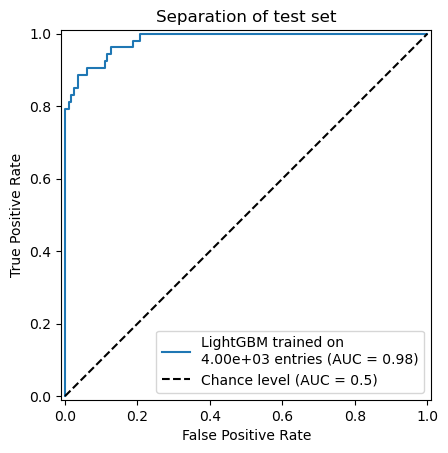

In [8]:
display_roc = RocCurveDisplay.from_predictions(
    ytest,
    ypred:= lgb_model.predict_proba(Xtest)[:,1],
    name=f"LightGBM trained on\n{len(ytrain):2.2e} entries",
    plot_chance_level=True,
)

_ = display_roc.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Separation of test set"
)

By inspecting the model, we see that not all features are equally important. We also see, that the model didn't get to overtrain.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

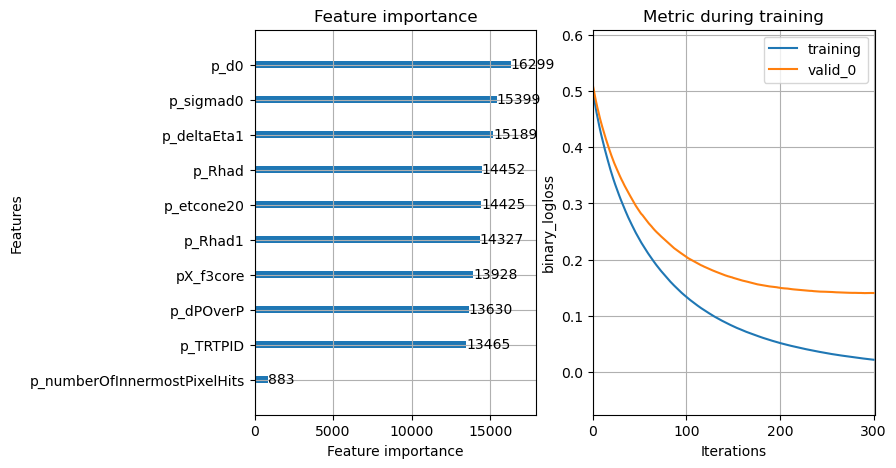

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,5))
lgb.plot_metric(lgb_model,ax=ax[1])
lgb.plot_importance(lgb_model,ax=ax[0],max_num_features=40)

# Regression

## By hand

# LightGBM

As before we start by separating the data into sets for training, testing, and validating.

In [10]:
Xtrain, Xrem, ytrain, yrem = train_test_split(X.loc[yelectron == 1],yenergy[yelectron==1], #Only train on particles that are actually electrons
                                              test_size=0.2,random_state=42)
Xval, Xtest, yval, ytest = train_test_split(Xrem,yrem,test_size=0.25,random_state=314)

In [11]:
param = {
    'objective': 'regression',
    'unbalanced_sets': True,
    'num_leaves': 298,
    'learning_rate': 0.045,
    'feature_fraction': 0.64,
    'bagging_fraction': 0.97,
    'bagging_freq': 5,
    'min_child_samples': 2,
}

lgb_model = lgb.LGBMRegressor(**param,n_estimators=1000, random_state=42)
lgb_model.fit(Xtrain, ytrain,eval_set=[(Xval,yval),(Xtrain,ytrain)],
             callbacks=[lgb.callback.early_stopping(stopping_rounds=10),timer:=Timer(every = 50)])

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.64, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64
[LightGBM] [Warning] bagging_fraction is set=0.97, subsample=1.0 will be ignored. Current value: bagging_fraction=0.97
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.64, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64
[LightGBM] [Warning] bagging_fraction is set=0.97, subsample=1.0 will be ignored. Current value: bagging_fraction=0.97
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 837, number of used features: 10
[LightG

LGBMRegressor(bagging_fraction=0.97, bagging_freq=5, feature_fraction=0.64,
              learning_rate=0.045, min_child_samples=2, n_estimators=1000,
              num_leaves=298, objective='regression', random_state=42,
              unbalanced_sets=True)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l2'>

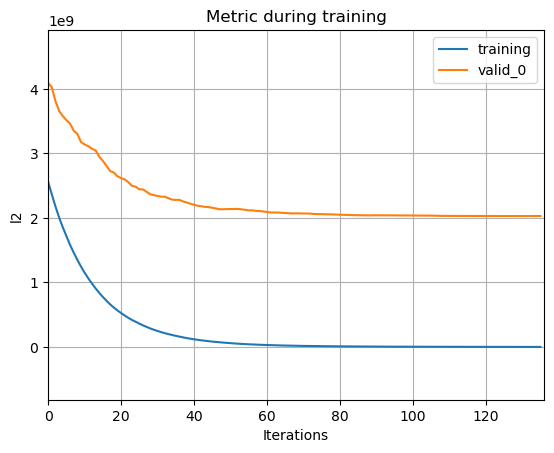

In [12]:
lgb.plot_metric(lgb_model)

In [13]:
energy_pred = lgb_model.predict(Xtest)

rel_dev = (energy_pred-ytest)/ytest

[LightGBM] [Warning] feature_fraction is set=0.64, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.97, subsample=1.0 will be ignored. Current value: bagging_fraction=0.97


[(-2.0, 5.0), Text(0, 0.5, 'Counts/53'), Text(0.5, 0, 'Relative deviation')]

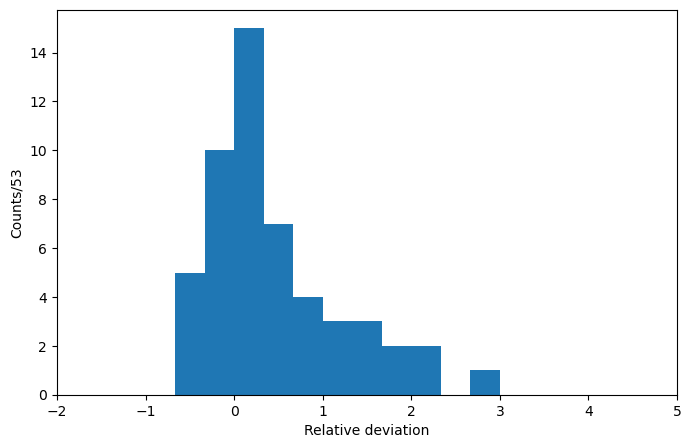

In [14]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
bins = np.linspace(-5,5,31)

xlabel = f"Relative deviation"
if largest:=np.min(rel_dev) > 5:
    bins[-1] = largest #Note that the last bin contains everything less than -5
    xlabel += f" - Zoomed in from {bins[0]:.2f}"
    
ax.hist(rel_dev, bins = bins)
ax.set(xlim=(-2,5),
      ylabel=f"Counts/{len(ytest)}",
      xlabel=xlabel)